In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc,accuracy_score,f1_score,precision_score,recall_score
import itertools
import joblib


In [2]:
df = pd.read_csv('Clean_Data/train_values.csv'); df.head()

,building_id,geo1,geo2,geo3,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,201801000561,20,2001,200101,2,2,15,303,18,18,...,0,0,0,0,0,0,0,0,0,0
1,360505001221,36,3604,360406,2,2,30,735,12,12,...,0,0,0,0,0,0,0,0,0,0
2,245606000381,24,2404,240403,2,2,9,391,14,14,...,0,0,0,0,0,0,0,0,0,0
3,234201000741,23,2309,230902,2,2,5,560,14,14,...,1,0,0,0,0,0,0,0,0,0
4,223707000531,22,2205,220503,3,0,16,310,18,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
y_train = pd.read_csv('Clean_Data/train_labels.csv')

In [4]:
columns = df.columns
df.shape

(609674, 42)

In [34]:
y_train.shape

(609674, 1)

In [5]:
"""
I will be dropping some of the columns as they are not necessary for the investigation
"""
df = df.drop(['building_id', 'height_ft_post_eq', 'count_floors_post_eq'], axis=1)
df.shape

(609674, 39)

In [6]:
"""
We will change the damage grade values into categorical strings for better visualisation
"""
df.damage_grade[df.damage_grade == 1] = 'low'
df.damage_grade[df.damage_grade == 2] = 'medium'
df.damage_grade[df.damage_grade == 3] = 'high'

/Users/flatiron/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


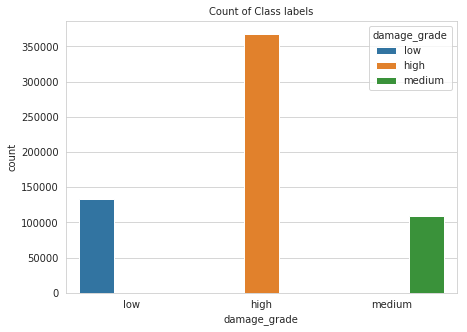

In [7]:
"""
We will check if the data is balanced
"""

sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'
plt.figure(figsize=(7,5))
plt.title('Count of Class labels', fontsize=10)
sns.countplot(x='damage_grade',data=df,hue='damage_grade')
plt.show()

In [8]:
print('Number of properties with low damage:{0:.2f}%'.format((len(df[df['damage_grade']=='low'])/len(df))*100))
print('Number of properties with medium damage:{0:.2f}%'.format((len(df[df['damage_grade']=='medium'])/len(df))*100))
print('Number of properties with high damage:{0:.2f}%'.format((len(df[df['damage_grade']=='high'])/len(df))*100))

Number of properties with low damage:21.79%
Number of properties with medium damage:17.90%
Number of properties with high damage:60.31%


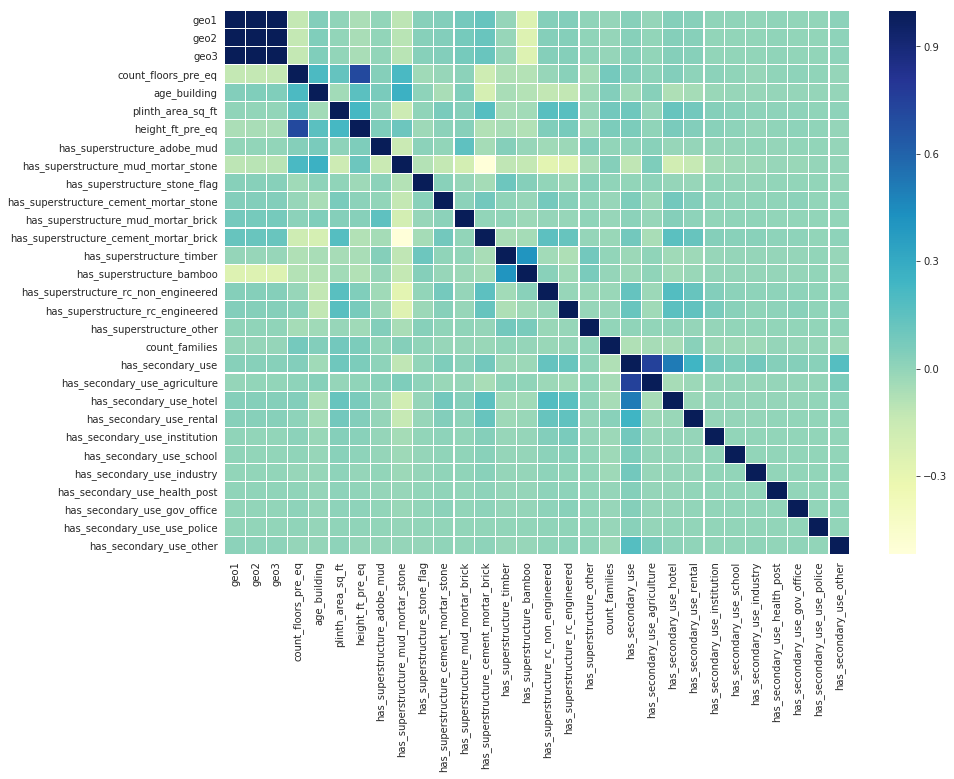

In [9]:
corrmat=df.corr(method='spearman')
f,ax=plt.subplots(figsize=(14,10))
sns.heatmap(corrmat,ax=ax,cmap="YlGnBu", linewidths=0.1)

We will first carry out a baseline model and then a randomforest model and then basis of our first model we will carry out further EDA.

In [10]:
"""
We need to make sure that there are no strings in our dataframe so we will turn them into categorical columns
"""
cat_col = []
for n,c in df.items():
    if pd.api.types.is_string_dtype(c):
        cat_col.append(c.name)
        df[n] = c.astype('category').cat.as_ordered()

In [11]:
cat_col # just to find out which columns were categorical

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'damage_grade',
 'legal_ownership_status']

In [12]:
# before we run our models we need to ensure that the labels are properly encoded

le = preprocessing.LabelEncoder()
for i in cat_col:
    df[i] = le.fit_transform(df[i])

In [35]:
# we will prepare our data for our models

X = df.drop('damage_grade', axis=1)
y = y_train['Labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((487739, 38), (121935, 38), (487739,), (121935,))

In [15]:
# we need to set our labels for our output results

labels=['Low','Medium','High']

Before we start building our model we will have some functions ready which can be used for outputing the results

In [16]:
def plot_confusion_matrix(cm, classes,normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
def print_class(m, y_pred):
    res = [format(accuracy_score(y_true=y_test, y_pred=y_pred),'.4f'), 
           format(precision_score(y_true=y_test, y_pred=y_pred, average='weighted' ), '.4f'),
           format(recall_score(y_true=y_test, y_pred=y_pred, average='weighted'), '.4f'), 
           format(f1_score(y_true=y_test, y_pred=y_pred, average='weighted'),'.4f')]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
    plt.show()
    
    print(f'accuracy score for our model is {res[0]}')
    print(f'precision score for our model is {res[1]}')
    print(f'recall score for our model is {res[2]}')
    print(f'f1 score for our model is {res[3]}')
    report = classification_report(y_test, y_pred)
    print('\n-------------------------------------\n')
    print('Classification report is as follows: ')
    print(report)
    


### Baseline model:

we will build our first baseline by randomly predicting the labels and then carrying out logistic regression to check our score

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('clf', LogisticRegression(random_state=123, class_weight='balanced'))])

# Fit the pipelines
pipe_lr.fit(X_train, y_train)

print(pipe_lr.score(X_test, y_test))

0.4893836880305081


Our baseline score is 0.61 so we need to make sure that we can build a model that is better than 0.61. We will start with trying to improve our logistic regressor with the help of smote and scaling our features and then see how it improves the performance of our model.

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [39]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)
X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())

KeyboardInterrupt: 

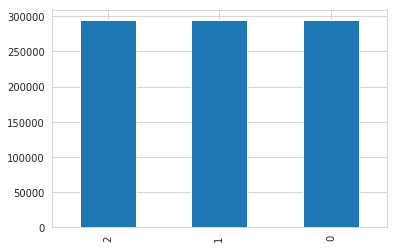

In [41]:
# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

In [42]:
parameters = {'C':[0.01, 0.1, 1,5, 10], 'penalty':['l2','l1']}
log_reg = LogisticRegression(class_weight='balanced')
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_reg.fit(X_train_new, y_train_new)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

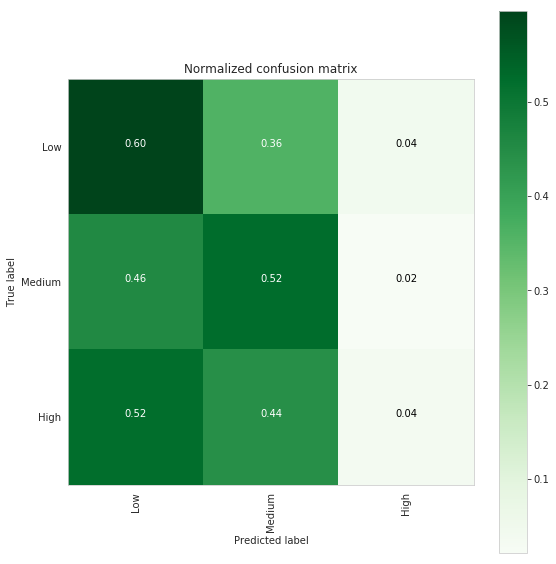

accuracy score for our model is 0.4800
precision score for our model is 0.4845
recall score for our model is 0.4800
f1 score for our model is 0.4651

-------------------------------------

Classification report is as follows: 
              precision    recall  f1-score   support

           0       0.65      0.60      0.62     73605
           1       0.28      0.52      0.36     26443
           2       0.17      0.04      0.06     21887

    accuracy                           0.48    121935
   macro avg       0.37      0.39      0.35    121935
weighted avg       0.48      0.48      0.47    121935



In [43]:
log_pred = log_reg.predict(X_test)
print_class(log_reg, log_pred)

In [45]:
joblib.dump(log_reg,'log_reg_model.pkl')

['log_reg_model.pkl']

## Random forest classifier

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2, shuffle = True, stratify = y)

params = {'max_depth':[2,3,5,7],'n_estimators':[20,50,100,200]}
rf=RandomForestClassifier(class_weight='balanced')
#grid=GridSearchCV(rf,param_grid=params,n_jobs=-1,verbose=1)
#rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

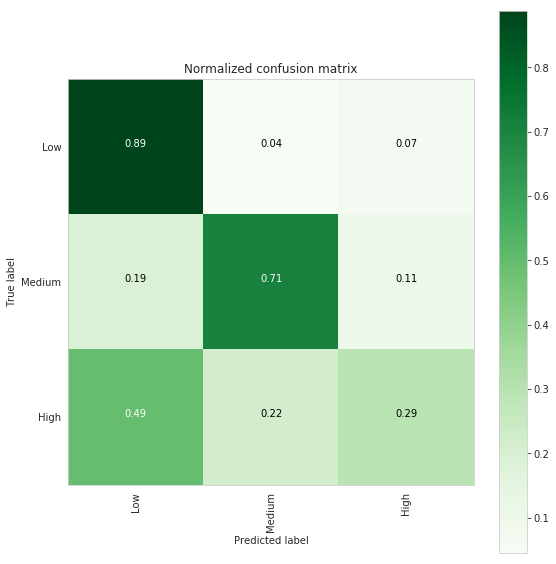

accuracy score for our model is 0.7423
precision score for our model is 0.7199
recall score for our model is 0.7423
f1 score for our model is 0.7268

-------------------------------------

Classification report is as follows: 
              precision    recall  f1-score   support

           0       0.81      0.89      0.85     73538
           1       0.70      0.71      0.71     26571
           2       0.45      0.29      0.35     21826

    accuracy                           0.74    121935
   macro avg       0.65      0.63      0.63    121935
weighted avg       0.72      0.74      0.73    121935



In [48]:
"""
uncomment rf if running this second time
"""

# rf = joblib.load('rf_first.pkl')
rf_pred = rf.predict(X_test)
print_class(rf, rf_pred)

In [52]:
joblib.dump(rf, 'rf_first.pkl')

['rf_first.pkl']

In [53]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [55]:
important_featurtes = rf_feat_importance(rf, X_train)
important_featurtes.head(10)

,cols,imp
5,plinth_area_sq_ft,0.171442
4,age_building,0.162176
2,geo3,0.155063
1,geo2,0.085549
6,height_ft_pre_eq,0.083684
15,has_superstructure_mud_mortar_stone,0.036974
0,geo1,0.034970
10,ground_floor_type,0.030691
9,roof_type,0.025977
8,foundation_type,0.024488


## Multiclass with custom metrics

In [61]:
import lightgbm as lgbm
from sklearn.preprocessing import LabelBinarizer

def predict_lgbm(lgb_model,x_test,y_test):
    lgb_prediction = lgb_model.predict(x_test)
    lgb_prediction = lgb_prediction.argmax(axis = 1)
    plt.figure(figsize=(8,8))
    plt.grid(b=False)
    cm = metrics.confusion_matrix(y_test_, lgb_prediction)
    plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix')
    lgb_F1 = f1_score(lgb_prediction, y_test, average = 'weighted')
    print("The Light GBM F1 is", lgb_F1)
    
def preprocess_cat_data_lgbm(train_data,cols):
    #print(cols)
    for col in train_data.columns:
        if(col in cols):
            std=LabelEncoder() 
            temp=list(train_data[col].values)
            res=std.fit_transform(temp)
            train_data[col]=res
    return train_data

def lgb_f1_score(y_pred,data):
    y_true = data.get_label().astype('int')
    #F1 score not improving in multiclass lgbm custom metric:https://github.com/Microsoft/LightGBM/issues/1483
    y_pred =y_pred.reshape((3,-1)).argmax(axis=0) 
    y_pred=np.round(y_pred)
    return 'f1', f1_score(y_true, y_pred,average='weighted'), True

def predict_lgbm(lgb_model,x_test,y_test):
    lgb_prediction = lgb_model.predict(x_test)
    lgb_prediction = lgb_prediction.argmax(axis = 1)
    lgb_F1 = f1_score(lgb_prediction, y_test, average = 'weighted')
    print("The Light GBM F1 is", lgb_F1)

In [62]:
train_data_lgbm = lgbm.Dataset(X_train, label=y_train)
test_data_lgbm = lgbm.Dataset(X_test, label=y_test)

params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'learning_rate': 0.005,
    'max_depth': 5,
    'num_leaves': 20,
    'is_unbalanced':True,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.5}

clf=lgbm.train(params,
                       train_data_lgbm,
                       valid_sets=[test_data_lgbm],
                       valid_names=['val'],
                       num_boost_round=15000,
                       feval=lgb_f1_score,
                       verbose_eval=500,
                       early_stopping_rounds=300)

Training until validation scores don't improve for 300 rounds
[500]	val's multi_logloss: 0.707878	val's f1: 0.637861
[1000]	val's multi_logloss: 0.682779	val's f1: 0.643965
[1500]	val's multi_logloss: 0.670764	val's f1: 0.647867
[2000]	val's multi_logloss: 0.663345	val's f1: 0.652536
[2500]	val's multi_logloss: 0.656899	val's f1: 0.658472
[3000]	val's multi_logloss: 0.651629	val's f1: 0.662843
[3500]	val's multi_logloss: 0.647614	val's f1: 0.667656
[4000]	val's multi_logloss: 0.644221	val's f1: 0.671929
[4500]	val's multi_logloss: 0.640898	val's f1: 0.675217
[5000]	val's multi_logloss: 0.637719	val's f1: 0.678359
[5500]	val's multi_logloss: 0.634674	val's f1: 0.680922
[6000]	val's multi_logloss: 0.632049	val's f1: 0.683848
[6500]	val's multi_logloss: 0.629712	val's f1: 0.68634
[7000]	val's multi_logloss: 0.627747	val's f1: 0.688812
[7500]	val's multi_logloss: 0.625885	val's f1: 0.690751
[8000]	val's multi_logloss: 0.624308	val's f1: 0.692098
[8500]	val's multi_logloss: 0.622727	val's f

In [65]:
joblib.dump(clf, 'gbm_first.pkl')

['gbm_first.pkl']

In [68]:
lgb_prediction = clf.predict(X_test)
lgb_prediction = lgb_prediction.argmax(axis = 1)

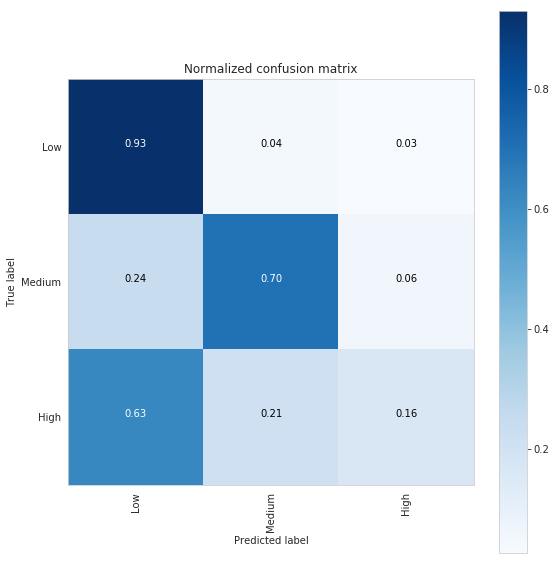

In [69]:
plt.figure(figsize=(8,8))
plt.grid(b=False)
cm = confusion_matrix(y_test, lgb_prediction)
plot_confusion_matrix(cm, classes=labels, normalize=True, title='Normalized confusion matrix')